In [1]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
import pickle

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

models_path = '/Users/Winston/GitHub/tensorflow_playground/tensorflow_models/MNIST_1FC_Softmax'

# Parameters
learning_rate = 0.1
training_epochs = 2
batch_size = 10
display_step = 1
log_step = 100

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_output = 10 # MNIST total classes (0-9 digits)
n_hidden_1 = 100 # 1st layer number of features

# TF Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition => 10 classes
y_ = tf.placeholder(tf.float32, [None, 10], name='LabelData')

# Helper functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Store layers weight & bias
weights = {
    'W1': weight_variable([n_input, n_hidden_1]),
    'W2': weight_variable([n_hidden_1, n_output])
}
biases = {
    'b1': bias_variable([n_hidden_1]),
    'b2': bias_variable([n_output])    
}


# Create model
def build_model(x, weights, biases):
    # Hidden layer with ReLU activation
    layer_1 = tf.add(tf.matmul(x, weights['W1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Output layer
    out_layer = tf.add(tf.matmul(layer_1, weights['W2']), biases['b2'])
    return out_layer


# Encapsulating all ops into scopes, making Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Build model
    logits = build_model(x, weights, biases)
    pred = tf.nn.softmax(logits)
    
with tf.name_scope('Loss'):
    # Softmax Cross entropy (cost function)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_), name = 'loss')
    # NOTE:
    # Since out_layer has NOT invoked softmax, leverage TF optimized function 
    # "softmax_cross_entropy_with_logits" to calculate cost

with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss, name = 'train_op')    
    
with tf.name_scope('Accuracy'):
    # Accuracy
    accuracy = tf.equal(tf.argmax(pred, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32), name = 'accuracy')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
## Training

# Initializing the variables
init = tf.initialize_all_variables()

saver = tf.train.Saver(tf.all_variables())

#train_cost_history, validation_cost_history, validation_accuracy_history = ([] for i in range(3))

with tf.Session() as sess:
    sess.run(init)
    log_avg_costs = list()
    # Training cycle
    for epoch in tqdm(range(training_epochs), ascii=True): 
#        epoch_avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            train_cost, _ = sess.run([loss, train_op], feed_dict={x: batch_xs, y_: batch_ys})
#            epoch_avg_cost += train_cost / total_batch
#            log_avg_costs.append(train_cost)
            if (i+1) % log_step == 0:
#                train_cost_history.append(np.mean(log_avg_costs))
#                log_avg_costs[:] = []
                val_cost, val_accuracy = sess.run([loss, accuracy], feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
#                validation_cost_history.append(val_cost)
#                validation_accuracy_history.append(val_accuracy)
        
        # Display training cost & validation accuracy per epoch step
#        if (epoch+1) % display_step == 0:
#            print("Epoch: {}, cost= {:.9f}".format(epoch+1, epoch_avg_cost))

    print("Optimization Finished!")  
    save_path = saver.save(sess, models_path + '/model.ckpt', global_step=training_epochs)
    print("Model save in file: %s" % save_path)
#    with open(models_path + '/history-10epochs.pickle', "wb") as f:
#        pickle.dump((train_cost_history, validation_cost_history, validation_accuracy_history), f)
    
    # Test model
    # Calculate accuracy
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

100%|##########| 2/2 [00:23<00:00, 11.48s/it]


Optimization Finished!
Model save in file: /Users/Winston/GitHub/tensorflow_playground/tensorflow_models/MNIST_1FC_Softmax/model.ckpt-2
Test Accuracy: 0.9696


In [7]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
import pickle

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Parameters
training_epochs = 2
batch_size = 10
log_step = 1000
models_path = '/Users/Winston/GitHub/tensorflow_playground/tensorflow_models/MNIST_1FC_Softmax'

with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(models_path)
    if ckpt and ckpt.model_checkpoint_path:
        #print(ckpt.model_checkpoint_path)
        persistenter = tf.train.import_meta_graph(ckpt.model_checkpoint_path + '.meta')
        persistenter.restore(sess, ckpt.model_checkpoint_path)
    else:
        print('No checkpoint file found')   
    
    #persistenter = tf.train.import_meta_graph(models_path + '/model-epochs-4.meta')
    #persistenter.restore(sess, models_path + '/model-epochs-4')
    print("Model restored.")
    #accuracy = tf.get_collection('accuracy')[0]
    accuracy = sess.graph.get_tensor_by_name('Accuracy/accuracy:0')
    loss = sess.graph.get_tensor_by_name('Loss/loss:0')
    print(loss)
    train_op = sess.graph.get_operation_by_name('SGD/train_op')
    print(train_op)
    x = sess.graph.get_tensor_by_name('InputData:0')
    y_ = sess.graph.get_tensor_by_name('LabelData:0')
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))    

    # Training cycle
    for epoch in tqdm(range(training_epochs), ascii=True): 
        total_batch = int(mnist.train.num_examples / batch_size)
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            train_cost, _ = sess.run([loss, train_op], feed_dict={x: batch_xs, y_: batch_ys})
            if (i+1) % log_step == 0:
                val_cost, val_accuracy = sess.run([loss, accuracy], feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
                print("Validate Cost & Accuracy:", val_cost, val_accuracy)
    print("Optimization Finished!")  
    save_path = persistenter.save(sess, models_path + '/model-epochs-6')
    print("Model save in file: %s" % save_path)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Model restored.
Tensor("Loss/loss:0", shape=(), dtype=float32)
name: "SGD/train_op"
op: "NoOp"
input: "^SGD/train_op/update_Variable/ApplyGradientDescent"
input: "^SGD/train_op/update_Variable_1/ApplyGradientDescent"
input: "^SGD/train_op/update_Variable_2/ApplyGradientDescent"
input: "^SGD/train_op/update_Variable_3/ApplyGradientDescent"

Test Accuracy: 0.9696
Validate Cost & Accuracy: 0.0954688 0.9702
Validate Cost & Accuracy: 0.0914922 0.9726
Validate Cost & Accuracy: 0.089764 0.973
Validate Cost & Accuracy: 0.0907149 0.9718
Validate Cost & Accuracy: 0.100955 0.9678


 50%|#####     | 1/2 [00:08<00:08,  8.59s/it]

Validate Cost & Accuracy: 0.0939832 0.9716
Validate Cost & Accuracy: 0.0936531 0.972
Validate Cost & Accuracy: 0.0821052 0.9738
Validate Cost & Accuracy: 0.0919771 0.9734
Validate Cost & Accuracy: 0.0883844 0.9734


100%|##########| 2/2 [00:16<00:00,  8.51s/it]


Optimization Finished!
Model save in file: /Users/Winston/GitHub/tensorflow_playground/tensorflow_models/MNIST_1FC_Softmax/model-epochs-6


In [ ]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
import pickle

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

models_path = '/Users/Winston/GitHub/tensorflow_playground/tensorflow_models/MNIST_1FC_Softmax'

# get all tensors' name with below list comprehension
# [tensor.name for tensor in tf.get_default_graph().as_graph_def().node]
# fetch tensor from graph using <name>:0 (0 refers to endpoint here)

with tf.Session() as sess:
    restorer = tf.train.import_meta_graph(models_path + '/model-epochs-6.meta')
    restorer.restore(sess, models_path + '/model-epochs-6')
    tf.train.write_graph(sess.graph.as_graph_def(), models_path, 'NN.pb', as_text=True)
    print("Model GraphDef protocol buffer written.")
    
    accuracy = sess.graph.get_tensor_by_name('Accuracy/accuracy:0')
    x = sess.graph.get_tensor_by_name('InputData:0')
    y_ = sess.graph.get_tensor_by_name('LabelData:0')
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


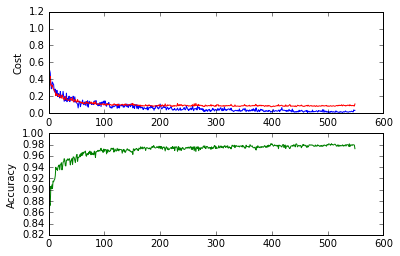

In [4]:
## Plot the learning curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure() 
# create figure window
gs = gridspec.GridSpec(2, 1)
# Creates grid 'gs' of 2 rows and 1 columns 
ax = plt.subplot(gs[0, 0])
# Adds subplot 'ax' in grid 'gs' at position [0,0]
ax.set_ylabel('Cost') 
ax.set_xlabel('Iterations') 
ax.plot(train_cost_history, 'b-')
ax.plot(validation_cost_history, 'r-')
fig.add_subplot(ax) 

bx = plt.subplot(gs[1, 0])
bx.set_ylabel('Accuracy') 
bx.plot(validation_accuracy_history, 'g-')
fig.add_subplot(bx)

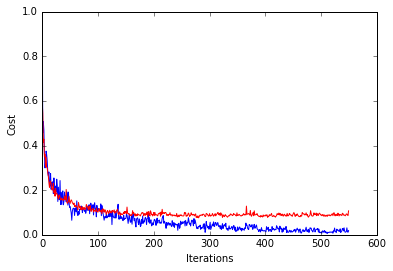

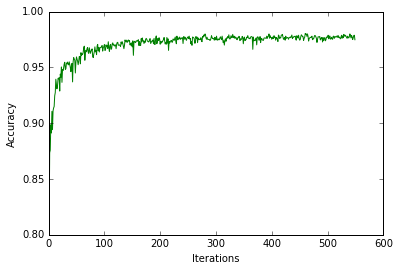

In [3]:
## Plot the learning curves

%matplotlib inline
import matplotlib.pyplot as plt
import pylab

plt.figure(1)
plt.plot(train_cost_history,'b-')
plt.plot(validation_cost_history, 'r-')
plt.ylabel('Cost')
plt.xlabel('Iterations')
pylab.ylim([0,1])

plt.figure(2)
plt.plot(validation_accuracy_history, 'g-')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')

In [5]:
print(validation_accuracy_history[-1])

0.9728
